In [0]:
# load your pictures
!wget --quiet -P /tmp https://i.ytimg.com/vi/YCaGYUIfdy4/maxresdefault.jpg
!wget --quiet -P /tmp https://upload.wikimedia.org/wikipedia/commons/b/b4/Vincent_Willem_van_Gogh_128.jpg
contentP = '/tmp/maxresdefault.jpg'
styleP = '/tmp/Vincent_Willem_van_Gogh_128.jpg'

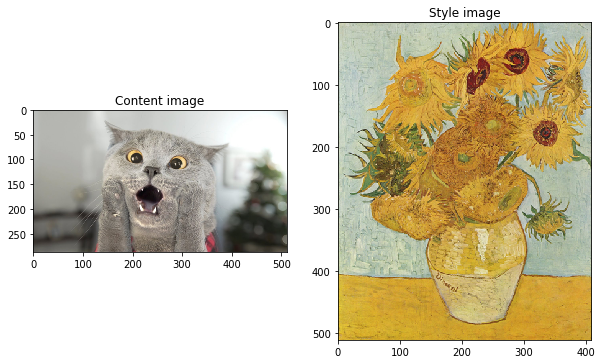

In [2]:
#images
import matplotlib.pyplot as plt #use matlab, interface for matplotlib
import matplotlib as mpl #plot 2D graphics
from PIL import Image

#matrix
import numpy as np

#other
import time
import functools

#ml
%tensorflow_version 1.x 
import tensorflow as tf

from tensorflow.python.keras.preprocessing import image as kpr_image
from tensorflow.python.keras import layers
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import losses
tf.enable_eager_execution() #for fast work

#mpl parameters
mpl.rcParams['figure.figsize'] = (10, 10)
mpl.rcParams['axes.grid'] = False

#download images
import os
img_dir = '/tmp'
if not os.path.exists(img_dir):
  os.makedirs(img_dir)

#load images
def load_img(path_to_img):
  img = Image.open(path_to_img)
  max_dim = 512 #may be more
  long = max(img.size)

  scale = max_dim/long #as coefficient
  
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS) #to int
  img = kpr_image.img_to_array(img)
  img = np.expand_dims(img, axis = 0)
  return img

#show images
def imshow(img, title = None):
  out = np.squeeze(img, axis = 0) #remove the batch dimension
  out = out.astype('uint8')
  plt.imshow(out)

  if title is not None:
    plt.title(title)
  plt.imshow(out) 

plt.figure(figsize = (10, 10))
content = load_img(contentP).astype('uint8')
style = load_img(styleP).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content image')

plt.subplot(1, 2, 2)
imshow(style, 'Style image')
plt.show()

In [0]:
def load_and_prep_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.VGG19.preprocess_input(img) #can be changed on another model
  return img

def deprocess_img(processed_img):
  x = processed_img.copy()

  if len(x.shape) == 4:
    x = np.squeeze(x, axis = 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of dimension [1, height, width, channel] or [height, width, channel]")

  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")  

  # perform the inverse of the preprocessiing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# build the model
def get_model():
  vgg = tf.keras.applications.VGG19.VGG19(include_top = False, weights = 'imagenet')
  vgg.trainable = False

  content_out = [vgg.get_layer(name).output for name in content_layers]
  style_out = [vgg.get_layer(name).output for name in style_layers]
  model_out = content_out + style_out
  return models.Model(vgg.input, model_out)

# computing loss for content images
def get_loss_content(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

def gram_matrix(input_tensor):
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a = True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  return tf.reduce_mean(tf.square(gram_style - gram_target))